In [77]:
## Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import os,sys
from glob import glob
import calendar
%matplotlib inline

In [78]:
plt.rcParams["figure.figsize"] = (20, 10)

## This notebook objective and Outline:

Key objective: Find what do Bostonian care when they pick a place to stay on AirBnb


1. What kind of accommodation do they have in Boston?

2. Which are generally get occupied?

3. Which factors make them so hot for bostonians?



## Gather data

Here we'll read all data of Airbnb Boston dataset

In [79]:
RAW_PATH = './raw_data'
files = glob(RAW_PATH+'/*.csv')
files

['./raw_data\\calendar.csv',
 './raw_data\\listings.csv',
 './raw_data\\reviews.csv']

### Exploring each dataset

We'll start with Calendar, Reviews, an Listings respectively.

Let's see what kind of data each dataset contains

### Calendar

In [80]:
calen_df = pd.read_csv(files[0], date_parser='date')
print(calen_df.info())
print("=="*40)
calen_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1308890 non-null  int64 
 1   date        1308890 non-null  object
 2   available   1308890 non-null  object
 3   price       643037 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB
None


,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN


Calendar dataset contains listing_id of each listing with its availability and price for each day

Half of the price is null

In [81]:
def price_cleaning(df:pd.DataFrame, col:str):
    """
    Clean columns related to prices
    INPUT:
    df: Dataframe that contains price-like values
    col: Columns name that contains price-like values
    """ 
    temp = df.copy()
    temp[col] = temp[col].str.replace(',', '')
    temp[col] = temp[col].str.replace('$', '')
    temp[col] = temp[col].astype(float) 
    temp[col] = temp[col].fillna(0)
    return temp[col]

In [82]:
calen_df['pn'] = calen_df['price'].isna()
calen_df.groupby(by=['available','pn'], as_index=False)['listing_id'].count().sort_values(by='listing_id',ascending=False)

,available,pn,listing_id
0,f,True,665853
1,t,False,643037


Based on this data, it's safe to assume that listing without price means that it's unavailable

In [83]:
calen_df['listing_id'] = calen_df['listing_id'].astype('string') 
calen_df['date'] = pd.to_datetime(calen_df['date']).dt.date
calen_df['date'] = calen_df['date'].astype('datetime64')

# Price are not in numeric format. Thus, we need to clean it 
calen_df['price'] = price_cleaning(df=calen_df,col='price')
calen_df['have_price'] = np.where(calen_df['price']==0,0,1)
calen_df.head(2)

C:\Users\racha\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  # Remove the CWD from sys.path while we load stuff.


,listing_id,date,available,price,pn,have_price
0,12147973,2017-09-05,f,0.0,True,0
1,12147973,2017-09-04,f,0.0,True,0


#### Features engineering

Let's extract some more information from this dataset by flagging day of week into this dataset

In [84]:
calen_df['day_of_week'] = pd.to_datetime(calen_df['date']).dt.day_name()
calen_df['wd_wn'] = np.where(
    (calen_df['day_of_week']=='Saturday') | (calen_df['day_of_week']=='Sunday'),
    'Weekend',
    'Weekday' 
)
calen_df.head()

,listing_id,date,available,price,pn,have_price,day_of_week,wd_wn
0,12147973,2017-09-05,f,0.0,True,0,Tuesday,Weekday
1,12147973,2017-09-04,f,0.0,True,0,Monday,Weekday
2,12147973,2017-09-03,f,0.0,True,0,Sunday,Weekend
3,12147973,2017-09-02,f,0.0,True,0,Saturday,Weekend
4,12147973,2017-09-01,f,0.0,True,0,Friday,Weekday


In [85]:
## Base on values down below we can assume that if the listing is booked/full they won't have price
calen_df.groupby(by=['have_price','available'])['listing_id'].count().head(50)

have_price  available
0           f            665853
1           t            643037
Name: listing_id, dtype: int64

Let's the occupied rate throughout the year

In [86]:
calen_df.groupby(by=['listing_id', 'have_price'], as_index=False)['date'].count()

,listing_id,have_price,date
0,10004575,0,275
1,10004575,1,90
2,10009367,0,365
3,10021398,0,37
4,10021398,1,328
...,...,...,...
6383,9993826,0,186
6384,9993826,1,179
6385,9998187,0,275
6386,9998187,1,90


In [87]:
# Calculating occupied_rate for each listing
occupied_rate = calen_df.groupby(by=['listing_id', 'have_price'], as_index=False)['date'].count().pivot_table(index=['listing_id'], columns=['have_price'], values=['date'])
occupied_rate = occupied_rate.reset_index()
occupied_rate.columns = ['listing_id','price_yes','price_no']
occupied_rate= occupied_rate.fillna(0)
occupied_rate['occupied_pct'] = occupied_rate.price_no/(occupied_rate.price_no+occupied_rate.price_yes)
occupied_rate.head()

,listing_id,price_yes,price_no,occupied_pct
0,10004575,275.0,90.0,0.246575
1,10009367,365.0,0.0,0.000000
2,10021398,37.0,328.0,0.898630
3,10032327,290.0,75.0,0.205479
4,10033322,186.0,179.0,0.490411


In [88]:
occupied_rate[occupied_rate.occupied_pct==1]

,listing_id,price_yes,price_no,occupied_pct
14,10036192,0.0,365.0,1.0
21,10051649,0.0,365.0,1.0
61,10127270,0.0,365.0,1.0
141,10567830,0.0,365.0,1.0
170,10742655,0.0,365.0,1.0
...,...,...,...,...
3351,9180965,0.0,365.0,1.0
3497,973695,0.0,365.0,1.0
3529,9854083,0.0,365.0,1.0
3563,9926796,0.0,365.0,1.0


There're 103 listing that is full all year around. Interesting

What are the occupied rates distribution in Boston

<AxesSubplot:xlabel='occupied_pct', ylabel='Count'>

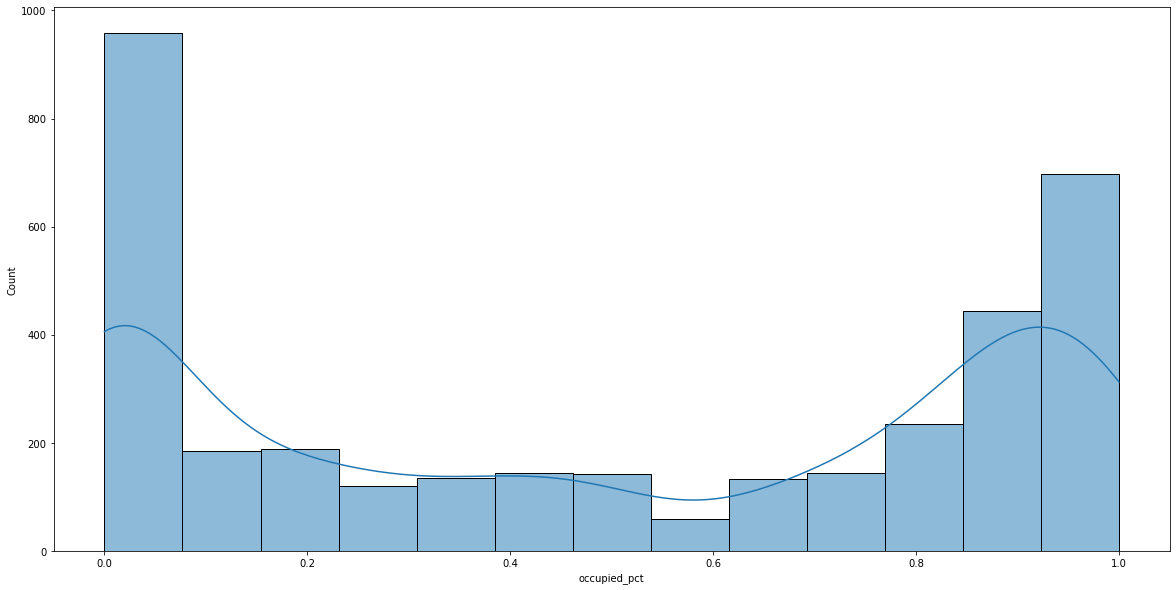

In [89]:
sns.histplot(occupied_rate.occupied_pct, kde=True)

It seems like occupied rate of listings in Boston is pretty much divided. It's either full all year around or barely get booked.

In [90]:
daily_availability = calen_df.groupby(by=['date', 'available'], as_index=False)['listing_id'].count().pivot_table(index=['date'], columns=['available'],values=['listing_id']).reset_index()
daily_availability.columns = ['date','full','vacant']
daily_availability['occupied_rate'] = daily_availability.full/(daily_availability.full+daily_availability.vacant)
daily_availability['total_listing'] = (daily_availability.full+daily_availability.vacant)
daily_availability.head(3)

,date,full,vacant,occupied_rate,total_listing
0,2016-09-06,3016,570,0.841049,3586
1,2016-09-07,2654,932,0.740100,3586
2,2016-09-08,2587,999,0.721417,3586


<AxesSubplot:xlabel='date', ylabel='total_listing'>

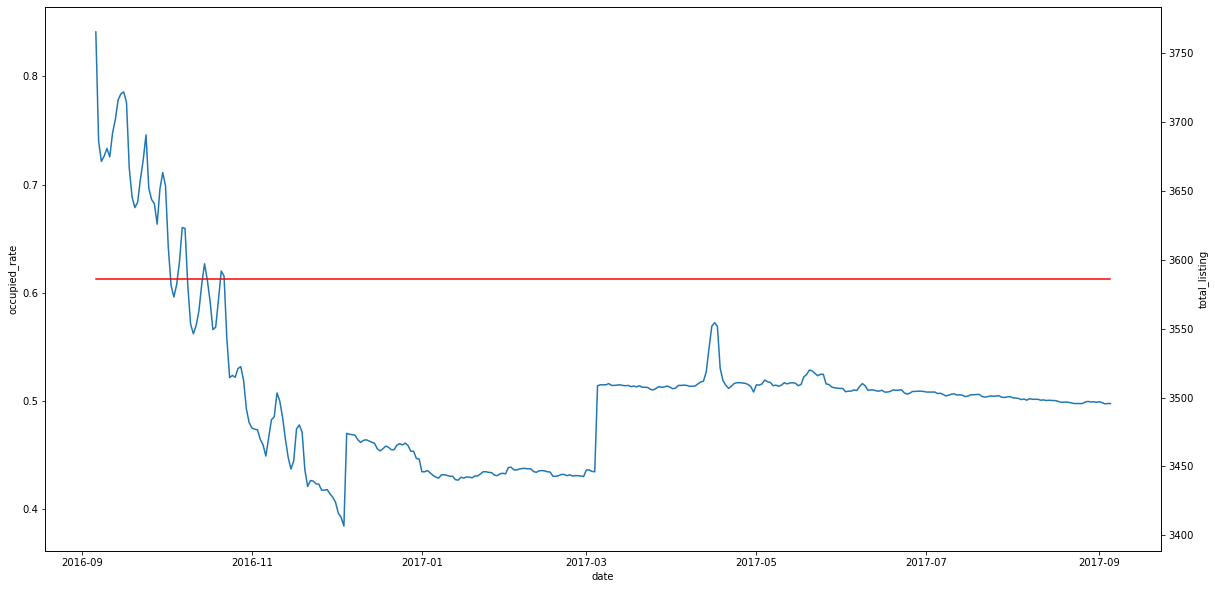

In [91]:
fig, ax = plt.subplots(1)
sns.lineplot(data=daily_availability, x='date',y='occupied_rate', ax=ax)
ax2 = ax.twinx()
sns.lineplot(data=daily_availability, x='date', y='total_listing', ax=ax2, color='red')

It's counter intuitive for me to that following Sep 2016 the occupancy rates are dropping

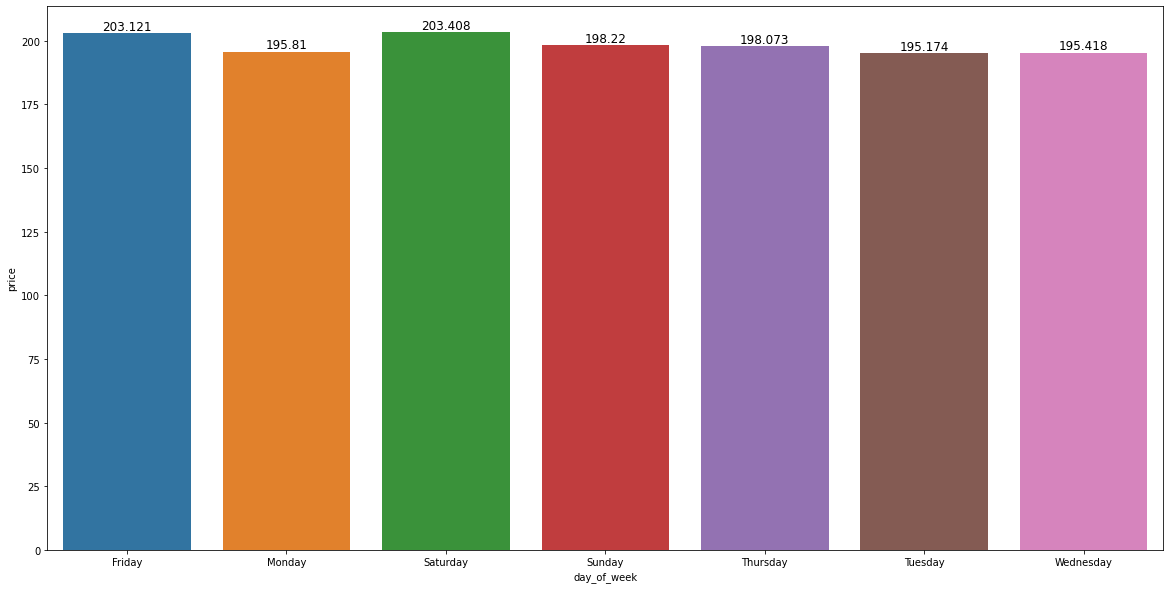

In [92]:
# Plotting average price of the listing by day of week
fig, ax = plt.subplots(1)
sns.barplot(
    data=calen_df.loc[calen_df['available']!='f'].groupby(by=['day_of_week'],
    as_index=False)['price'].mean(),
    x='day_of_week',
    y='price',
    ax=ax)
for container in ax.containers:
    ax.bar_label(container, fontsize=12)

This is as expected that price on weekend is a little higher than weekday

### Reviews

In [93]:
review_df = pd.read_csv(files[2])
review_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


It looks like in order to extract useful information from this review would requried Tokenization of comments.
For the interest of time, we'll not do it in this project. Thus, Reviews dataset will not be used

### Listing

In [94]:
listing = pd.read_csv(files[1])
listing.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN


Listing data contains a lot information about the listings

In [95]:
listing.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

Let's look into some rows of data this dataset provided

Below are sample data of listing dataset

In [96]:
listing.iloc[:2,:20].head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247


In [97]:
listing.iloc[:2,20:30].head()

,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url
0,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,https://a2.muscache.com/im/pictures/5936fef0-b...
1,https://www.airbnb.com/users/show/2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,https://a2.muscache.com/im/users/2572247/profi...


In [98]:
listing.iloc[:2,30:40].head()

,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed
0,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale
1,https://a2.muscache.com/im/users/2572247/profi...,Roslindale,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United States",Roslindale,Roslindale


In [99]:
listing.iloc[:2,40:60].head()

,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet
0,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN
1,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.286241,-71.134374,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",NaN


In [100]:
listing.iloc[:2,60:80].head()

,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating
0,$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,NaN,0,0,0,0,2016-09-06,0,NaN,NaN,NaN
1,$65.00,$400.00,NaN,$95.00,$10.00,0,$0.00,2,15,a week ago,NaN,26,54,84,359,2016-09-06,36,2014-06-01,2016-08-13,94.0


In [101]:
listing.iloc[:2,80:].head()

,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,10.0,9.0,10.0,10.0,9.0,9.0,f,NaN,NaN,t,moderate,f,f,1,1.3


In [102]:
# Let's take only relevant columns we think might related to our interest that is occupancy rate
listing_required = listing[['id', 'experiences_offered',
       'transit','host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost','host_verifications',
        'street','neighbourhood_cleansed', 'city',
        'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet',
       'price', 'weekly_price', 'monthly_price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'number_of_reviews','review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value','cancellation_policy']]
listing_required.head(2)

,id,experiences_offered,transit,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_verifications,street,neighbourhood_cleansed,...,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy
0,12147973,none,"The bus stop is 2 blocks away, and frequent. B...",NaN,NaN,NaN,f,"['email', 'phone', 'facebook', 'reviews']","Birch Street, Boston, MA 02131, United States",Roslindale,...,1125,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,moderate
1,3075044,none,Plenty of safe street parking. Bus stops a few...,within an hour,100%,100%,f,"['email', 'phone', 'facebook', 'linkedin', 'am...","Pinehurst Street, Boston, MA 02131, United States",Roslindale,...,15,36,94.0,10.0,9.0,10.0,10.0,9.0,9.0,moderate


In [103]:
listing_required.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           3585 non-null   int64  
 1   experiences_offered          3585 non-null   object 
 2   transit                      2295 non-null   object 
 3   host_response_time           3114 non-null   object 
 4   host_response_rate           3114 non-null   object 
 5   host_acceptance_rate         3114 non-null   object 
 6   host_is_superhost            3585 non-null   object 
 7   host_verifications           3585 non-null   object 
 8   street                       3585 non-null   object 
 9   neighbourhood_cleansed       3585 non-null   object 
 10  city                         3583 non-null   object 
 11  property_type                3582 non-null   object 
 12  room_type                    3585 non-null   object 
 13  accommodates      

In [104]:
listing_required.isna().mean().sort_values(ascending=False)

square_feet                    0.984379
monthly_price                  0.752301
weekly_price                   0.751185
security_deposit               0.625662
transit                        0.359833
cleaning_fee                   0.308787
review_scores_accuracy         0.229568
review_scores_location         0.229289
review_scores_value            0.229010
review_scores_checkin          0.228731
review_scores_cleanliness      0.228173
review_scores_communication    0.228173
review_scores_rating           0.226778
host_acceptance_rate           0.131381
host_response_rate             0.131381
host_response_time             0.131381
bathrooms                      0.003905
bedrooms                       0.002789
beds                           0.002510
property_type                  0.000837
city                           0.000558
extra_people                   0.000000
number_of_reviews              0.000000
maximum_nights                 0.000000
minimum_nights                 0.000000


### Cleaning some data

This data have many useful attributes. However they're not workable format

In [105]:
# These columns are mostly null values
listing_required = listing_required.drop(columns=['neighbourhood_cleansed','square_feet'])

# Longterm_promo is created to represent listing that provide discount for longstay
listing_required['longterm_promo'] = np.where(((listing_required.weekly_price.isna())|(listing_required.monthly_price.isna())),
        1,
        0)

# We have longterm_promo to represent monthly, weekly price already
# experiences_offered and city don't provide useful information
listing_required = listing_required.drop(columns=['monthly_price','weekly_price','experiences_offered','city'])
listing_required['id'] = listing_required['id'].astype('string')

In [106]:
# Some of these columns can be use number representation. Thus, we changing them to numerical values

tf_map = {'f':0,'t':1}
response_rate_map = dict(zip(['within an hour', 'within a few hours', 'within a day',
       'a few days or more',''],
       [0, 1, 2, 3,np.nan])
       )
cancel_strictness = dict(zip(['flexible','moderate', 'strict', 'super_strict_30'],
       [0, 1, 2, 3])
       )
listing_required['host_is_superhost']= listing_required['host_is_superhost'].apply(lambda x: tf_map[x]).astype('float64')
listing_required['host_response_time'] = listing_required['host_response_time'].fillna('').apply(lambda x: response_rate_map[x]).astype('float64') 
listing_required['host_verifications'] = listing_required['host_verifications'].apply(lambda x: x.count(','))
listing_required['cancellation_policy'] = listing_required['cancellation_policy'].apply(lambda x: cancel_strictness[x]).astype('float64')

# Let's use only summarized scores to represnt the reviews: review_scores_value
listing_required = listing_required.drop(columns=['review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication'
 ]
)

# Reformating these rate values as they are in string format
for col in ['host_response_rate', 'host_acceptance_rate']:
    fix_rates =[]
    for val in listing_required[col]:
        try:
            fix_rates.append(val.replace('%',''))
        except:
            fix_rates.append(val)
    listing_required[col] = fix_rates
    listing_required[col] = listing_required[col].astype('float64')

# Try extracting street information
listing_required['street'] =listing_required['street'].apply(lambda x: x.split(',')[0])
 

In [107]:
listing_required.street.value_counts()

Commonwealth Avenue     109
Beacon Street            91
Boylston Street          82
Washington Street        79
Tremont Street           66
                       ... 
Jeffries Street           1
Everett Street            1
Sumner St                 1
Lubec St                  1
George St Somerville      1
Name: street, Length: 1046, dtype: int64

In [108]:
listing_required.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      3585 non-null   string 
 1   transit                 2295 non-null   object 
 2   host_response_time      3114 non-null   float64
 3   host_response_rate      3114 non-null   float64
 4   host_acceptance_rate    3114 non-null   float64
 5   host_is_superhost       3585 non-null   float64
 6   host_verifications      3585 non-null   int64  
 7   street                  3585 non-null   object 
 8   property_type           3582 non-null   object 
 9   room_type               3585 non-null   object 
 10  accommodates            3585 non-null   int64  
 11  bathrooms               3571 non-null   float64
 12  bedrooms                3575 non-null   float64
 13  beds                    3576 non-null   float64
 14  bed_type                3585 non-null   

In [109]:
# Applying the same cleaning method we use with price column from calendar dataset
for price_col in ['price', 'security_deposit','cleaning_fee', 'extra_people']:
    listing_required[price_col] = price_cleaning(listing_required,  price_col)

C:\Users\racha\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  # Remove the CWD from sys.path while we load stuff.


In [110]:
# fig, ax = plt.subplots(2)
# sns.barplot(data=listing_required.groupby(by=['property_type', 'room_type'],as_index=False)['id'].count().sort_values(by='id',ascending=False),
#             x='property_type', 
#             y='id', 
#             hue='room_type',
#             ax=ax[0])
# sns.barplot(data=listing_required.groupby(by=['room_type'],as_index=False)['id'].count(), x='room_type', y='id', ax=ax[1])
# ax[0].set_title('Number of listing by property type')
# ax[0].set_ylim(0,2000)
# ax[0].legend(loc='upper right')
# ax[1].set_title('Number of listing by room type')
# for axs in ax:
#     for container in axs.containers:
#         axs.bar_label(container, fontsize=12)
    

### Let's answer the questions

1. What kind of accommodation do they have in Boston?

2. Which are generally get occupied?

3. Which factors make them so hot for bostonians?

#### A.) Accomodation types in Boston

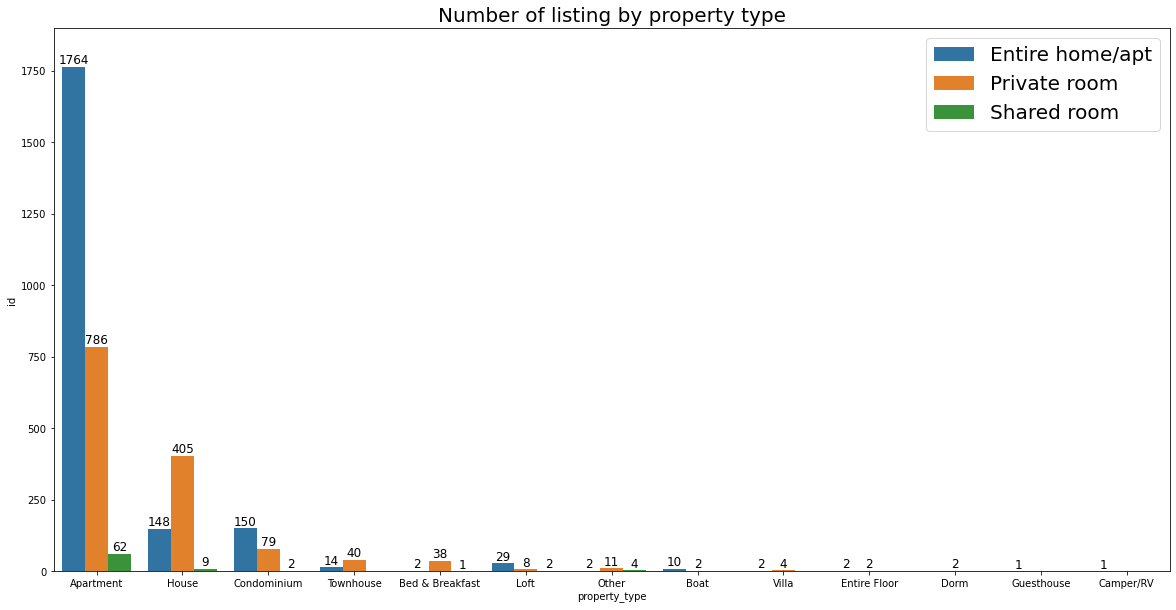

In [111]:
fig, ax = plt.subplots()
sns.barplot(data=listing_required.groupby(by=['property_type', 'room_type'],as_index=False)['id'].count().sort_values(by='id',ascending=False),
            x='property_type', 
            y='id', 
            hue='room_type',
            ax=ax)
# sns.barplot(data=listing_required.groupby(by=['room_type'],as_index=False)['id'].count(), x='room_type', y='id', ax=ax[1])
ax.set_title('Number of listing by property type', fontsize=20)
ax.set_ylim(0,1900)
# ax.set_xticks()
ax.legend(loc='upper right', fontsize=20)
# ax[1].set_title('Number of listing by room type')
# for axs in ax:
for container in ax.containers:
    ax.bar_label(container, fontsize=12)
    

In [112]:
listing_required.property_type.value_counts()/listing_required.shape[0]

Apartment          0.728591
House              0.156764
Condominium        0.064435
Townhouse          0.015063
Bed & Breakfast    0.011437
Loft               0.010879
Other              0.004742
Boat               0.003347
Villa              0.001674
Entire Floor       0.001116
Dorm               0.000558
Guesthouse         0.000279
Camper/RV          0.000279
Name: property_type, dtype: float64

Mostly listings are belong to Apartment, House, and Condominium types

In [113]:
# Let's focus only these three property type
listing_required = listing_required.loc[listing_required['property_type'].isin(['Apartment','House','Condominium'])] 

#### B.) Which are generally occupied?

To answer this question we need occupancy rates data from calendar dataset

In [114]:
# Join with occupied_rate
listing_required = listing_required.merge(occupied_rate[['listing_id','occupied_pct']],  
                                          how='left', 
                                          left_on='id', 
                                          right_on='listing_id').drop(columns=['listing_id'])
listing_required.head(1)

,id,transit,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_verifications,street,property_type,room_type,...,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_location,review_scores_value,cancellation_policy,longterm_promo,occupied_pct
0,12147973,"The bus stop is 2 blocks away, and frequent. B...",NaN,NaN,NaN,0.0,3,Birch Street,House,Entire home/apt,...,1,0.0,2,1125,0,NaN,NaN,1.0,1,0.0


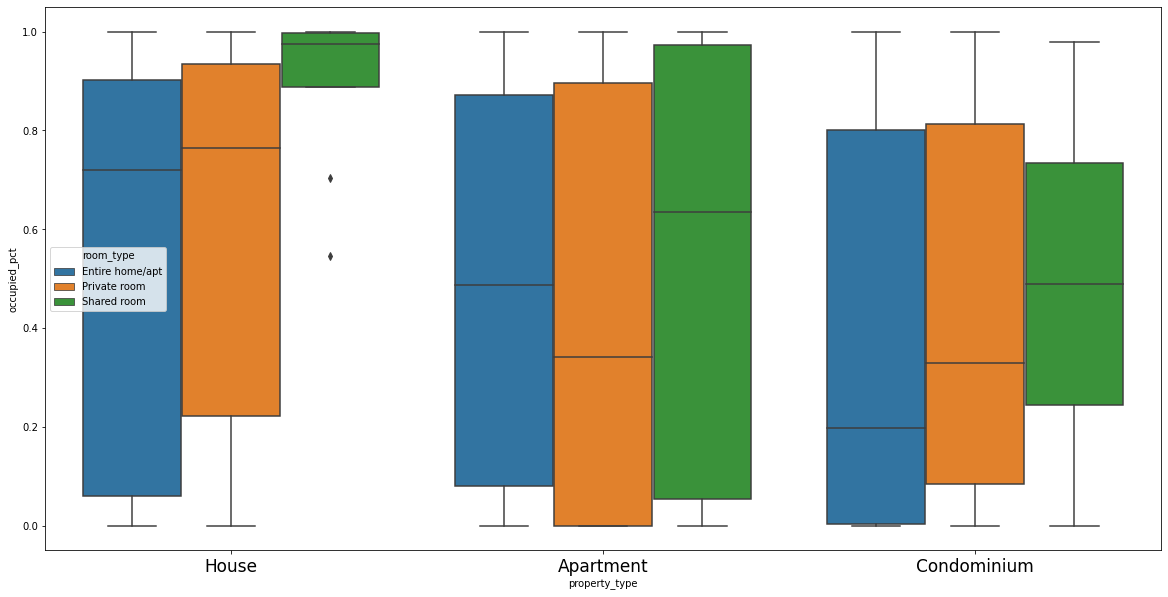

In [115]:
sns.boxplot(data=listing_required, x='property_type', y='occupied_pct', hue='room_type')
plt.tick_params(axis='x', labelsize=17)

Look like House are a clear cut winner in Boston. Especially in Shared room type

####  Which factors make them so hot for bostonians?

The assumption would be price

(0.0, 800.0)

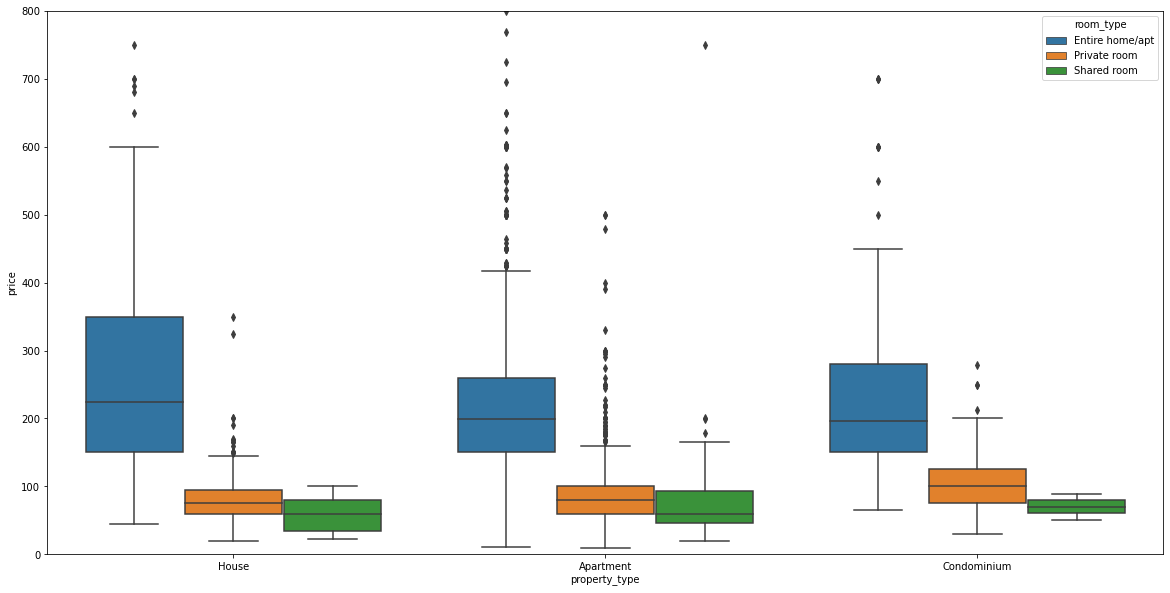

In [116]:
fig, ax = plt.subplots()
sns.boxplot(data=listing_required, x='property_type', y='price', hue='room_type', ax=ax)
ax.set_ylim(0,800)

It's likely that price is the reason as we can see that House are having slightly lower price comparing to the other 2.

However, it's not that conclusive. We're trying to use another approach to get the quantitative evidence: __Linear Regression__

#### Data preparation for Regression model

In [117]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in tqdm(cat_cols):
        try:
            # for each cat add dummy var, drop original column
            print(f'{col} first value is: {df[col].unique()[0]}')
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=False, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [118]:
# Let's find out which columns are still categorical|String columns
listing_required.dtypes[listing_required.dtypes=='object'].index

Index(['id', 'transit', 'street', 'property_type', 'room_type', 'bed_type',
       'amenities'],
      dtype='object')

In [131]:
# id doesn't give any interpretable data
# Transit and Amenities will require NLP which will not be covered here
# lin_raw = listing_required.drop(columns=['id','transit','street','amenities'])
lin_raw = listing_required.drop(columns=['id','transit','amenities'])
# lin_raw = create_dummy_df(df=lin_raw, cat_cols=['property_type', 'room_type', 'bed_type'], dummy_na=False)
lin_raw = create_dummy_df(df=lin_raw, cat_cols=['property_type', 'room_type','street', 'bed_type'], dummy_na=False)
lin_raw.head(3)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 55.26it/s]

property_type first value is: House
room_type first value is: Entire home/apt
street first value is: Birch Street
bed_type first value is: Real Bed


,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_verifications,accommodates,bathrooms,bedrooms,beds,price,...,street_poplar st,street_sulllivan street,street_vinal street,street_west,street_波士顿,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed
0,NaN,NaN,NaN,0.0,3,4,1.5,2.0,3.0,250.0,...,0,0,0,0,0,0,0,0,0,1
1,0.0,100.0,100.0,0.0,6,2,1.0,1.0,1.0,65.0,...,0,0,0,0,0,0,0,0,0,1
2,1.0,100.0,88.0,1.0,3,2,1.0,1.0,1.0,65.0,...,0,0,0,0,0,0,0,0,0,1


Let's impute missing values for columns with null

In [132]:
lin_raw.isna().mean().sort_values(ascending=False)[:10]

review_scores_location      0.227900
review_scores_value         0.227606
host_response_time          0.130984
host_acceptance_rate        0.130984
host_response_rate          0.130984
bathrooms                   0.003524
bedrooms                    0.002937
beds                        0.002349
street_Oak Street           0.000000
street_Old Morton Street    0.000000
dtype: float64

In [133]:
lin_raw.isna().mean().sort_values(ascending=False).index[:10]

Index(['review_scores_location', 'review_scores_value', 'host_response_time',
       'host_acceptance_rate', 'host_response_rate', 'bathrooms', 'bedrooms',
       'beds', 'street_Oak Street', 'street_Old Morton Street'],
      dtype='object')

In [134]:
# Create fill data with mean function
fill_mean = lambda col: col.fillna(col.mean())

In [135]:
for col in lin_raw.isna().mean().sort_values(ascending=False).index[:10]:
    lin_raw.loc[lin_raw[col].isna(), col] = lin_raw[col].mean()

In [136]:
lin_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3405 entries, 0 to 3404
Columns: 1053 entries, host_response_time to bed_type_Real Bed
dtypes: float64(17), int32(1), int64(6), uint8(1029)
memory usage: 4.1 MB


In [137]:
# Import libraries used to make linear model
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [138]:
X,Y = lin_raw.drop(columns=['occupied_pct']), lin_raw['occupied_pct']
save_col = X.columns
# Scaling X so we can compare impact of each features with coefficient
X = MinMaxScaler().fit_transform(X=X)
X = pd.DataFrame(X,columns=save_col)
# X = X.drop(columns=['number_of_reviews'])
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:           occupied_pct   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     2.513
Date:                Fri, 23 Sep 2022   Prob (F-statistic):           2.26e-75
Time:                        12:06:22   Log-Likelihood:                -341.28
No. Observations:                3405   AIC:                             2781.
Df Residuals:                    2356   BIC:                             9214.
Df Model:                        1048                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [139]:
# Save model result to dataframe
html_var_summary = summary.tables[1].as_html()
model_data = pd.read_html(html_var_summary, header=0, index_col=0)[0] 
model_data.head(3)

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.5196,0.068,7.671,0.000,0.387,0.652
host_response_time,-0.0650,0.039,-1.671,0.095,-0.141,0.011
host_response_rate,-0.1672,0.076,-2.203,0.028,-0.316,-0.018


These are the top features that impact occupancy rate of listing

In [140]:
model_data[model_data['P>|t|']<=0.05].sort_values('coef',ascending=False)[:30]

,coef,std err,t,P>|t|,[0.025,0.975]
number_of_reviews,0.7964,0.098,8.101,0.000,0.604,0.989
street_Claremont Park,0.7291,0.322,2.262,0.024,0.097,1.361
street_Dean Road,0.7181,0.322,2.230,0.026,0.087,1.350
street_Charlesgate West,0.7016,0.322,2.177,0.030,0.069,1.334
street_Aspinwall Rd,0.6925,0.323,2.145,0.032,0.059,1.325
street_Jersey Street,0.6667,0.323,2.067,0.039,0.034,1.299
street_Allandale Street,0.6634,0.326,2.036,0.042,0.024,1.303
street_Schuyler Street,0.6459,0.324,1.994,0.046,0.011,1.281
street_Oakmere Street,0.6376,0.323,1.972,0.049,0.003,1.272
street_Fisher Avenue,0.6371,0.323,1.974,0.048,0.004,1.270


What affect occupancy rates aside from location?

In [151]:
model_data[(model_data['P>|t|']<=0.05)&~(model_data.index.str.contains('street'))].sort_values('coef',ascending=False).head(30)

,coef,std err,t,P>|t|,[0.025,0.975]
number_of_reviews,0.7964,0.098,8.101,0.000,0.604,0.989
const,0.5196,0.068,7.671,0.000,0.387,0.652
price,0.5008,0.210,2.381,0.017,0.088,0.913
cleaning_fee,0.3911,0.052,7.560,0.000,0.290,0.493
room_type_Shared room,0.2926,0.043,6.845,0.000,0.209,0.376
cancellation_policy,0.2625,0.028,9.354,0.000,0.207,0.318
property_type_House,0.2148,0.030,7.060,0.000,0.155,0.274
review_scores_location,0.1762,0.088,1.991,0.047,0.003,0.350
property_type_Condominium,0.1581,0.032,4.905,0.000,0.095,0.221
property_type_Apartment,0.1467,0.026,5.718,0.000,0.096,0.197


Price, Shared room type, cancellation_policy seems to be another deciding factors

What counterintuitive is Price as I expected it to show negative relationship. 